# Recommender System Testing

The focus of this notebook is to test various code snippest, processing, subcomponents and integration of subcomponents for the recommender system

## Data Processing

External databases are initially used to test and train the recommender system so no actual pre-processing is required for that but when an online version is created and data is logged this will need to be processed and stored. For now the csv ratings file will be loaded and mappings will be created from user and movie ids to indexes. A sparse matrix will then be created to make indexing much easier, for this project double indexing will be done as it is more efficient than having a full sparse matrix.

In [92]:
import csv
import time
import os
import random
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

external_data_path = "../data/external/"
image_path = "images/"

In [93]:
# Choose small or large dataset: False=small, True=large
# large_dataset = True
large_dataset = False

if(large_dataset):
    folder_name = external_data_path + "ml-32m"
else:
    folder_name = external_data_path + "ml-latest-small"
file_name = "ratings.csv" 
file_path = os.path.join(folder_name, file_name)

# User and movie mappings
user_to_idx = {}
idx_to_user = {}
movie_to_idx = {}
idx_to_movie = {}

# Sparse Lists for user and movie ratings
user_ratings_train = []
user_ratings_test = []
movie_ratings_train = []
movie_ratings_test = []


test_count = 0
train_count = 0
start_time = time.time()
try:
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.reader(csvfile)
        header = next(csv_reader)
        for row in csv_reader:
            user_id = row[0]
            movie_id = row[1]
            rating = float(row[2])

            if user_id not in user_to_idx:
                user_idx = len(user_to_idx)
                user_to_idx[user_id] = user_idx
                idx_to_user[user_idx] = user_id
                user_ratings_test.append([])
                user_ratings_train.append([])

            if movie_id not in movie_to_idx:
                movie_idx = len(movie_to_idx)
                movie_to_idx[movie_id] = movie_idx
                idx_to_movie[movie_idx] = movie_id
                movie_ratings_train.append([]) 
                movie_ratings_test.append([])

            rand = random.random()
            if rand < 0.8:
                user_ratings_train[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_train[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                train_count += 1
            else:
                user_ratings_test[user_to_idx[user_id]].append((movie_to_idx[movie_id], rating))
                movie_ratings_test[movie_to_idx[movie_id]].append((user_to_idx[user_id], rating))
                test_count += 1

except FileNotFoundError:
    print(f"File {file_path} not found.")
except Exception as e:
    print(f"An error occurred: {e}")

end_time = time.time()
print("Finished")
print("Time taken:", end_time - start_time, "seconds")

print("Train Count:", train_count)
print("Test Count:", test_count)

Finished
Time taken: 0.12536883354187012 seconds
Train Count: 80665
Test Count: 20171


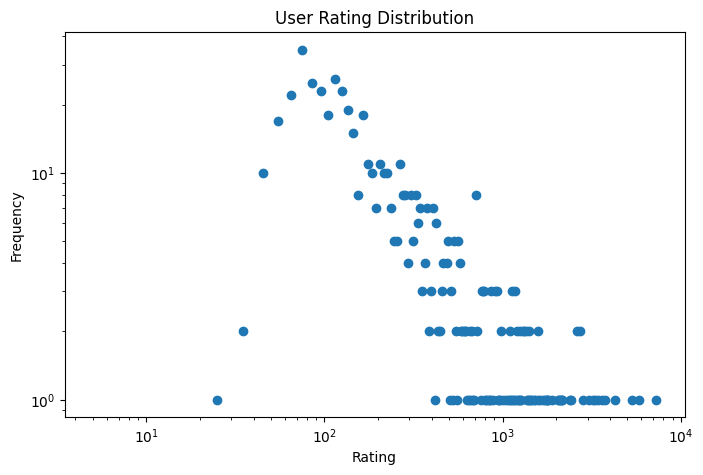

In [94]:
user_total_ratings = []

for row in user_ratings_train:
    user_sum = sum([rating for _, rating in row])
    user_total_ratings.append(user_sum)

all_user_ratings = [rating for rating in user_total_ratings]
user_rating_counts = Counter(all_user_ratings)
user_ratings = np.array(sorted(user_rating_counts.keys()))
user_frequencies = np.array([user_rating_counts[r] for r in user_ratings])

user_bin_edges = np.arange(0, max(user_total_ratings) + 10, 10)
user_frequencies, user_bins = np.histogram(user_total_ratings, bins=user_bin_edges)
user_bin_centers = 0.5 * (user_bins[1:] + user_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(user_bin_centers, user_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('User Rating Distribution')
plt.savefig(image_path + 'user_rating_distribution.svg')
plt.show()

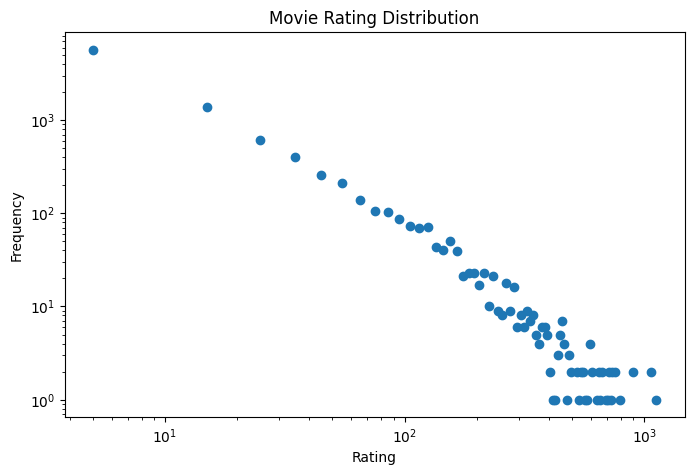

In [95]:
movie_total_ratings = []

for row in movie_ratings_train:
    movie_sum = sum([rating for _, rating in row])
    movie_total_ratings.append(movie_sum)

all_movie_ratings = [rating for rating in movie_total_ratings]
movie_rating_counts = Counter(all_movie_ratings)
movie_ratings = np.array(sorted(movie_rating_counts.keys()))
movie_frequencies = np.array([movie_rating_counts[r] for r in movie_ratings])

movie_bin_edges = np.arange(0, max(movie_total_ratings) + 10, 10)
movie_frequencies, movie_bins = np.histogram(movie_total_ratings, bins=movie_bin_edges)
movie_bin_centers = 0.5 * (movie_bins[1:] + movie_bins[:-1])

plt.figure(figsize=(8,5))
plt.scatter(movie_bin_centers, movie_frequencies)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Movie Rating Distribution')
plt.savefig(image_path + 'movie_rating_distribution.svg')
plt.show()

In [96]:
# Hyperparameters
lam = 0.1
gamma = 0.1
num_epochs = 100

# Configure Biases
user_biases = np.zeros(len(user_ratings_train))
item_biases = np.zeros(len(movie_ratings_train))
training_loss = []
training_RMSE = []
testing_RMSE = []

# Estimate biases with loss function
for epoch in range(num_epochs):
    for u in range(len(user_ratings_train)):
        bias = 0
        counter = 0
        for movie_idx, rating in user_ratings_train[u]:
            bias += (rating - item_biases[movie_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        user_biases[u] = bias

    for m in range(len(movie_ratings_train)):
        bias = 0
        counter = 0
        for user_idx, rating in movie_ratings_train[m]:
            bias += (rating - user_biases[user_idx])
            counter += 1
        bias = lam * bias / ((lam * counter) + gamma)
        item_biases[m] = bias

    train_loss = 0
    count = 0
    train_error = 0
    for u, user_ratings in enumerate(user_ratings_train):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            train_error += (rating - pred) * (rating - pred)
            count += 1 
    train_rmse = np.sqrt(train_error / (count + 1e-10))
    train_loss = (lam * (train_error)) + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2)))
    training_loss.append(train_loss)
    training_RMSE.append(train_rmse)

    test_loss = 0
    test_error = 0
    count = 0
    for u, user_ratings in enumerate(user_ratings_test):
        for movie_idx, rating in user_ratings:
            pred = user_biases[u] + item_biases[movie_idx]
            test_error += (rating - pred) * (rating - pred)
            count += 1
    test_rmse = np.sqrt(test_error / (count + 1e-10))
    testing_RMSE.append(test_rmse)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

Epoch 1/100, Loss: 6232.5713, Train RMSE: 0.8051, Test RMSE: 0.8790
Epoch 2/100, Loss: 6040.7302, Train RMSE: 0.7914, Test RMSE: 0.8663
Epoch 3/100, Loss: 6012.9328, Train RMSE: 0.7903, Test RMSE: 0.8655
Epoch 4/100, Loss: 5996.1834, Train RMSE: 0.7901, Test RMSE: 0.8653
Epoch 5/100, Loss: 5982.5365, Train RMSE: 0.7900, Test RMSE: 0.8652
Epoch 6/100, Loss: 5971.1078, Train RMSE: 0.7900, Test RMSE: 0.8652
Epoch 7/100, Loss: 5961.5099, Train RMSE: 0.7900, Test RMSE: 0.8652
Epoch 8/100, Loss: 5953.4461, Train RMSE: 0.7900, Test RMSE: 0.8653
Epoch 9/100, Loss: 5946.6708, Train RMSE: 0.7900, Test RMSE: 0.8654
Epoch 10/100, Loss: 5940.9780, Train RMSE: 0.7900, Test RMSE: 0.8655
Epoch 11/100, Loss: 5936.1948, Train RMSE: 0.7901, Test RMSE: 0.8656
Epoch 12/100, Loss: 5932.1757, Train RMSE: 0.7901, Test RMSE: 0.8657
Epoch 13/100, Loss: 5928.7988, Train RMSE: 0.7902, Test RMSE: 0.8658
Epoch 14/100, Loss: 5925.9615, Train RMSE: 0.7902, Test RMSE: 0.8659
Epoch 15/100, Loss: 5923.5774, Train RMSE: 

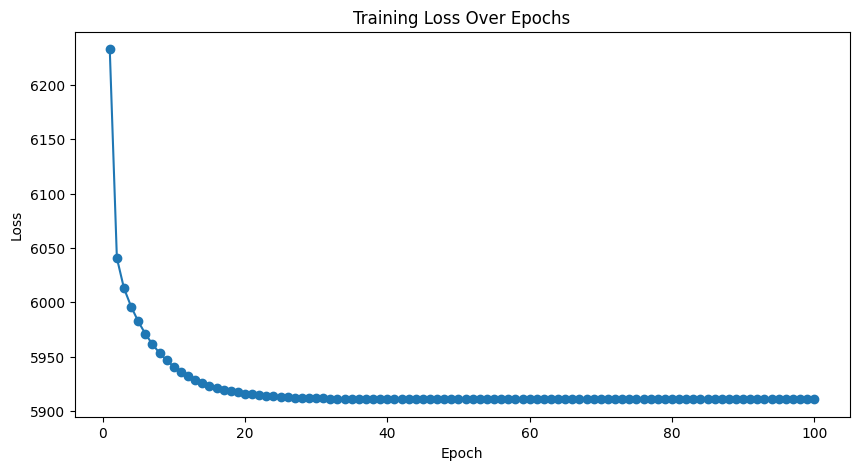

In [97]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

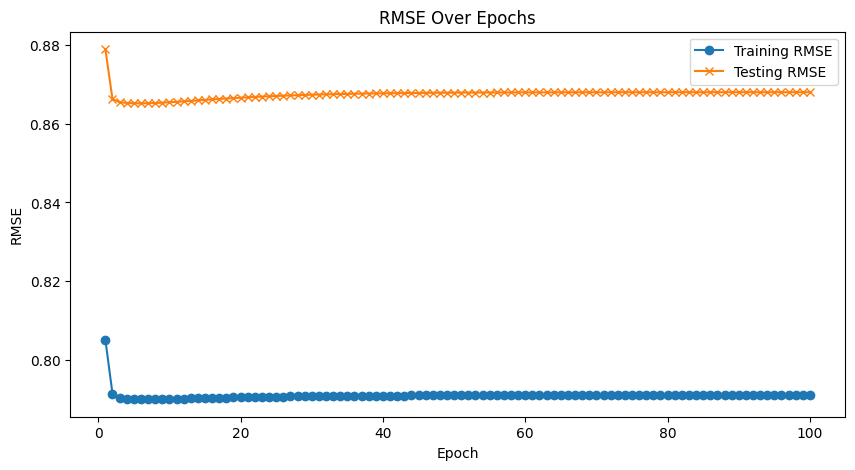

In [98]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()

In [102]:
def training(num_epochs=100, lam=0.1, gamma=0.1, tau=0.1, embeddings_dim=20, scale=1):
    user_embeddings = np.random.normal(0, scale, (len(user_ratings_train), embeddings_dim))
    item_embeddings = np.random.normal(0, scale, (len(movie_ratings_train), embeddings_dim))
    user_biases = np.zeros(len(user_ratings_train))
    item_biases = np.zeros(len(movie_ratings_train))
    training_loss = []
    training_RMSE = []
    testing_RMSE = []

    for epoch in range(num_epochs):
        for u in range(len(user_ratings_train)):
            bias = 0
            counter = 0
            user = 0
            for movie_idx, rating in user_ratings_train[u]:
                bias += lam * (rating - ((user_embeddings[u].T @ item_embeddings[movie_idx]) + item_biases[movie_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            user_biases[u] = bias
            
            user_term = 0
            user_inverse_term = 0
            for movie_idx, rating in user_ratings_train[u]:
                user_inverse_term += lam * ((item_embeddings[movie_idx].T @ item_embeddings[movie_idx]) + (tau * np.eye(embeddings_dim)))
                user_term += lam * item_embeddings[movie_idx] * (rating - user_biases[u] - item_biases[movie_idx])
            user = np.linalg.solve(user_inverse_term, user_term)
            user_embeddings[u] = user

        for m in range(len(movie_ratings_train)):
            bias = 0
            counter = 0
            for user_idx, rating in movie_ratings_train[m]:
                bias += lam * (rating - ((user_embeddings[user_idx].T @ item_embeddings[m]) + user_biases[user_idx]))
                counter += 1
            bias = bias / ((lam * counter) + gamma)
            item_biases[m] = bias

            item_term = 0
            item_inverse_term = 0
            for user_idx, rating in movie_ratings_train[u]:
                item_inverse_term += lam * ((user_embeddings[user_idx].T @ user_embeddings[user_idx]) + (tau * np.eye(embeddings_dim)))
                item_term += lam * user_embeddings[user_idx] * (rating - user_biases[user_idx] - item_biases[m])
            item = np.linalg.solve(item_inverse_term, item_term)
            item_embeddings[u] = item

        train_loss = 0
        count = 0
        train_error = 0
        for u, user_ratings in enumerate(user_ratings_train):
            for movie_idx, rating in user_ratings:
                pred = (user_embeddings[u].T @ item_embeddings[movie_idx]) + user_biases[u] + item_biases[movie_idx]
                train_error += (rating - pred) * (rating - pred)
                count += 1 
        train_rmse = np.sqrt(train_error / (count + 1e-10))
        train_loss = (lam * (train_error)) \
            + (gamma * (np.sum(user_biases**2) + np.sum(item_biases**2))) \
            + (tau * (np.sum(user_embeddings.T @ user_embeddings) + np.sum(item_embeddings.T @ item_embeddings)))
        training_loss.append(train_loss)
        training_RMSE.append(train_rmse)

        test_loss = 0
        test_error = 0
        count = 0
        for u, user_ratings in enumerate(user_ratings_test):
            for movie_idx, rating in user_ratings:
                pred = user_biases[u] + item_biases[movie_idx]
                test_error += (rating - pred) * (rating - pred)
                count += 1
        test_rmse = np.sqrt(test_error / (count + 1e-10))
        testing_RMSE.append(test_rmse)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

    return training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings

In [ ]:
# Hyperparameters
lam = 1
gamma = 1
tau = 2
num_epochs = 20
embeddings_dim = 10
const = 1

scale = const/np.sqrt(embeddings_dim)
training_loss, training_RMSE, testing_RMSE, user_embeddings, item_embeddings = training(
    num_epochs=num_epochs,
    lam=lam,
    gamma=gamma,
    tau=tau,
    embeddings_dim=embeddings_dim,
    scale=scale)

Epoch 1/20, Loss: 138408.8929, Train RMSE: 0.8005, Test RMSE: 0.8853
Epoch 2/20, Loss: 135669.4248, Train RMSE: 0.7803, Test RMSE: 0.8665
Epoch 3/20, Loss: 135385.2526, Train RMSE: 0.7791, Test RMSE: 0.8656
Epoch 4/20, Loss: 135222.9309, Train RMSE: 0.7789, Test RMSE: 0.8654
Epoch 5/20, Loss: 135091.1683, Train RMSE: 0.7788, Test RMSE: 0.8653
Epoch 6/20, Loss: 134980.7968, Train RMSE: 0.7788, Test RMSE: 0.8653
Epoch 7/20, Loss: 134888.0703, Train RMSE: 0.7788, Test RMSE: 0.8653
Epoch 8/20, Loss: 134810.1423, Train RMSE: 0.7788, Test RMSE: 0.8654
Epoch 9/20, Loss: 134744.6490, Train RMSE: 0.7788, Test RMSE: 0.8655
Epoch 10/20, Loss: 134689.6067, Train RMSE: 0.7789, Test RMSE: 0.8656
Epoch 11/20, Loss: 134643.3482, Train RMSE: 0.7789, Test RMSE: 0.8657
Epoch 12/20, Loss: 134604.4719, Train RMSE: 0.7789, Test RMSE: 0.8658
Epoch 13/20, Loss: 134571.7998, Train RMSE: 0.7790, Test RMSE: 0.8659
Epoch 14/20, Loss: 134544.3418, Train RMSE: 0.7790, Test RMSE: 0.8660
Epoch 15/20, Loss: 134521.265

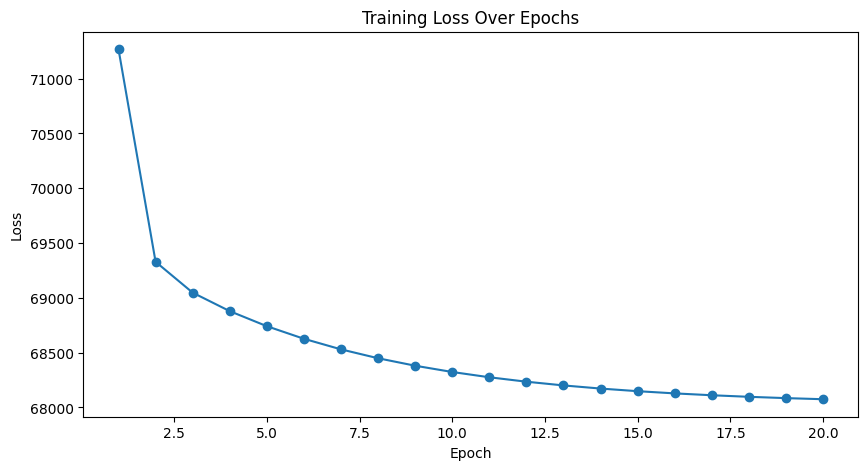

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.savefig(image_path + 'bias_trianing_loss.svg')
plt.show()

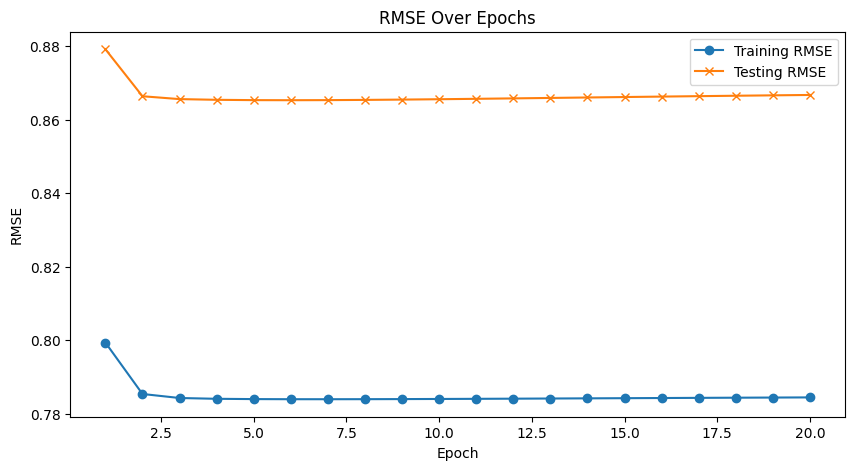

In [114]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), training_RMSE, marker='o', label='Training RMSE')
plt.plot(range(1, num_epochs + 1), testing_RMSE, marker='x', label='Testing RMSE')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE Over Epochs')
plt.savefig(image_path + 'bias_rmse.svg')
plt.show()